In [ ]:
#https://gym-trading-env.readthedocs.io/en/latest/rl_tutorial.html
#https://medium.com/@sthanikamsanthosh1994/custom-gym-environment-stock-trading-for-reinforcement-learning-stable-baseline3-629a489d462d

### Understand the action space
Positions
I have seen many environments that consider actions such as BUY, SELL. In my experience, it is a mistake to consider a reinforcement learning agent in the same way as a trader. Because, behind a trade, what really matter is the : position reached. In the environment, we label each position by a number : (example with pair BTC/USD)

1 : All of our portfolio is converted into BTC. (=BUY ALL)

0 : All of our portfolio is converted into USD. (=SELL ALL)

Now, we can imagine half position and other variants :

0.5 : 50% in BTC & 50% in USD

Even : 0.1 : 10% in BTC & 90% in USD ….

# ------------------------------------ Trading Bot --------------------------------------

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging #logger
#https://www.youtube.com/watch?v=SMZfgeHFFcA
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
#from network import DeepQNetwork
#from replay_memory import ReplayBuffer
#tf.get_logger().setLevel('ERROR')

import pandas as pd
import time

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import datetime

In [4]:
from src.env.environment import *
from src.env.portfolio import *
from src.utils.utils import *
from src.agent.agent import *

In [5]:
from settings import *

In [6]:
#from pandas.tseries.holiday import USFederalHolidayCalendar

In [7]:
import psycopg2 as pg

In [8]:
from prettytable import PrettyTable

In [9]:
# »»»»»»»»»»»»»»»»» STOCKS ««««««««««««««««««««z

STOCKS={'amazon':'AMZN','apple':'AAPL','netflix':'NFLX','google':'GOOG','Accenture':'ACN',
       'alibaba':'BABA','Turtle Beach':'HEAR','Disney':'DIS',
       'LG Display':'LPL','microsoft':'MICS','sony':'SONY',
       'Cenovus Energy':'CVE','YPF':'YPF','SHELL':'SHEL','Petrobras':'PBR',
       'Coca-Cola':'KO','PespsiCo':'PEP','Unilever':'UL','Kimberly-Clark':'KMB',
       'Mondelez':'MDLZ'}

#STOCKS = {'amazon':'AMZN'}

# dir where parquete file will be created
stocks_dir = '/dataset/stocks_aux/'

#*****************************************************************

In [10]:
def turn_of_logger():
    logger=logging.getLogger()
    for handler in logger.handlers[:]:  #make a copy of the list
        logger.removeHandler(handler)
    return logger

In [11]:
strin_format='%(i)s, %(market_return)s,%(pr)s,%(Sharpe)s,%(score)s,%(avg_score)s,%(best_score)s,%(loss)s,%(n_steps)s,%(pr_val)s,%(score_val)s, %(avg_score_val)s'
def initLogging(filename, logger_name):
    logger=turn_of_logger()
    logger.setLevel(logging.DEBUG)
    formatter=logging.Formatter(fmt='%(asctime)s,%(message)s',datefmt='%Y-%m-%d,%H:%M:%S')
    #formatter=logging.Formatter(fmt='%(message)s')
    fh=logging.FileHandler(filename)
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    return logger


    # sh=logging.StreamHandler(sys.stdout)
    # sh.setFormatter(formatter)
    # logger.addHandler(sh)


### ------------------------------- Reading and preparing data -----------------------------------------

In [12]:
df_training=pd.read_parquet("./data/raw/data_for_model_v2.parquet")
df_training.shape

(6630, 35)

In [13]:
#check if index is sorted. if yes ==Ture
df_training.datetime.is_monotonic_increasing

True

In [14]:
df_training.head(5)

,ticker,datetime,date,hour,holidays,n_weekday,n_hour,open,high,low,...,source10_y,source9_y,source8_y,source7_y,source6_y,source5_y,source4_y,source3_y,source2_y,source1_y
3,AAPL,2022-04-06 07:00:00,2022-04-06,07:00:00,0,2,7,173.330000,173.350000,172.500000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,AAPL,2022-04-06 08:00:00,2022-04-06,08:00:00,0,2,8,172.690000,175.230000,172.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
5,AAPL,2022-04-06 09:00:00,2022-04-06,09:00:00,0,2,9,172.360001,173.139999,171.020004,...,0.000000,0.0,0.0,0.0,0.362349,0.0,0.0,0.000000,0.0,0.0
6,AAPL,2022-04-06 10:00:00,2022-04-06,10:00:00,0,2,10,171.130005,171.580002,170.130005,...,-0.203831,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
7,AAPL,2022-04-06 11:00:00,2022-04-06,11:00:00,0,2,11,170.839996,171.740005,170.490005,...,0.027694,0.0,0.0,0.0,0.000000,0.0,0.0,-0.000264,0.0,0.0


In [15]:
#df_training=df_training[(df_training.relevance_score>=0.5]

In [16]:
#df_training.loc[0:1,['volume']]=1

In [17]:
#Because I am not using all data, I can fill in with other value different from 0. The first value never will be 0.
df_training['volume'] = df_training['volume'].replace(0, np.nan).ffill()

In [18]:
#check 80% of split in days
split_value=int(len(df_training)*0.9)

In [19]:
df_training.iloc[split_value-1:split_value,:]['date']

16023    2024-02-02
Name: date, dtype: object

In [20]:
#filter the dates where sentiment is not available

#Select Validation first
df_validation=df_training[(df_training.date>=datetime.date(2024,2,3))&(df_training.date<=datetime.date(2024,4,25))]
print("Validation: ",df_validation.shape)
#check if index is sorted. if yes ==Ture
print(df_validation.datetime.is_monotonic_increasing)
# selece Traning second -check to improve this
df_training=df_training[(df_training.date>=datetime.date(2022,1,1))&(df_training.date<datetime.date(2024,2,2))]
#df_training=df_training[(df_training.date>=datetime.date(2024,1,1))&(df_training.date<datetime.date(2024,4,2))]
print("Training: ",df_training.shape)
#check if index is sorted. if yes ==Ture
print(df_training.datetime.is_monotonic_increasing)

Validation:  (663, 35)
True
Training:  (5954, 35)
True


In [21]:
df_validation

,ticker,datetime,date,hour,holidays,n_weekday,n_hour,open,high,low,...,source10_y,source9_y,source8_y,source7_y,source6_y,source5_y,source4_y,source3_y,source2_y,source1_y
16083,AAPL,2024-02-05 07:00:00,2024-02-05,07:00:00,0,0,7,186.300000,187.400000,185.780000,...,0.523133,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
16084,AAPL,2024-02-05 08:00:00,2024-02-05,08:00:00,0,0,8,186.870000,187.580000,184.630000,...,0.422161,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
16085,AAPL,2024-02-05 09:00:00,2024-02-05,09:00:00,0,0,9,188.149994,188.360001,185.839996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
16086,AAPL,2024-02-05 10:00:00,2024-02-05,10:00:00,0,0,10,186.669998,187.759995,186.110001,...,0.350849,0.152268,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
16087,AAPL,2024-02-05 11:00:00,2024-02-05,11:00:00,0,0,11,187.250000,188.490005,187.230103,...,-0.031302,0.000000,0.000000,0.090812,0.046833,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17731,AAPL,2024-04-16 15:00:00,2024-04-16,15:00:00,0,1,15,169.990005,170.014999,169.279999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
17732,AAPL,2024-04-16 16:00:00,2024-04-16,16:00:00,0,1,16,169.340000,177.000000,162.223200,...,0.000000,0.000000,0.000000,0.345585,0.000000,0.0,0.0,0.0,0.0,0.0
17733,AAPL,2024-04-16 17:00:00,2024-04-16,17:00:00,0,1,17,169.500000,169.710000,169.370000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
17734,AAPL,2024-04-16 18:00:00,2024-04-16,18:00:00,0,1,18,169.475000,169.690000,169.380000,...,0.000000,0.000000,-0.134847,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [22]:
# ---------------- arrange columns-----------------------------

In [23]:
l1=list(df_training.columns)[2:55] #remove ticker, datetime 

In [24]:
df_training=df_training[l1]

In [25]:
df_validation=df_validation[l1]

In [26]:
 #---------------------------------------------------------------------

In [27]:
def _remove_linear_tendecy (x):
    return np.ediff1d(x, to_begin=1)

In [28]:
def _simple_net_return (x):
    """
        Fractional change between the current and a prior element.
        Computes the fractional change from the immediately previous row by default. 
        This is useful in comparing the fraction of change in a time series of elements.
    """
    result=x.pct_change()
    result.fillna(0,inplace=True)
    return result

In [29]:
def _log_return (x):
    result=np.log(x/x.shift(1))
    result.fillna(0,inplace=True)
    return (result)

In [30]:

 #---------------------------------------------------------------------

In [31]:
# #df_training is a DataFrame with columns : "open", "high", "low", "close", "Volume USD"
for dataframe in ['df_training','df_validation']:
    #---------------------------------------------------------------------
    #eval(dataframe)["feature_nweek"] = eval(dataframe)["n_weekday"]
    #eval(dataframe)["feature_holiday"] =  eval(dataframe)["holidays"]
    #eval(dataframe)["feature_nhour"] =  eval(dataframe)["n_hour"]
    
    #Create the feature : ( close[t] - close[t-1] )/ close[t-1]
    #df_training["diff_close"] = df_training['close'].diff()
    #eval(dataframe)["feature_close"] = ( eval(dataframe)["close"]) /  eval(dataframe)["close"].abs().max() 
    #eval(dataframe)["feature_close"] = _remove_linear_tendecy(eval(dataframe)["close"]) 
    #eval(dataframe)["feature_close"] = _simple_net_return(eval(dataframe)["close"]) 
    eval(dataframe)["feature_close"] = _log_return(eval(dataframe)["close"]) 
    
    # Create the feature : open[t] / close[t]
    eval(dataframe)["feature_open"] = _log_return(eval(dataframe)["open"]) 
    #eval(dataframe)["feature_open"] = ( eval(dataframe)["open"])/  eval(dataframe)["close"].abs().max() 
    
    # Create the feature : high[t] / close[t]
    eval(dataframe)["feature_high"] = _log_return(eval(dataframe)["high"]) 
    #eval(dataframe)["feature_high"] = ( eval(dataframe)["high"])/  eval(dataframe)["close"].abs().max() 
    
    # Create the feature : low[t] / close[t]
    eval(dataframe)["feature_low"] = _log_return(eval(dataframe)["low"]) 
    #eval(dataframe)["feature_low"]= ( eval(dataframe)["low"])/  eval(dataframe)["close"].abs().max() 
    
    #eval(dataframe)["feature_volume"] =  eval(dataframe)["volume"].apply(lambda x: np.log(x) if x!=0 else x)/  eval(dataframe)["close"].abs().max() 
    eval(dataframe)["feature_volume"] = _log_return(eval(dataframe)["volume"])     
    #eval(dataframe)["feature_volume"] =  eval(dataframe)["volume"]/  (eval(dataframe)["close"].abs().max()*1000000)
    #create columns for  relevance_score (x) and ticket_sentiment_score (y)
    # l1 is from 11 to 55 because I am selecting from score20_x to score1_y
    # for column in l1:
    #     if "source" in column:
    #         column_name="feature_"+column
    #         eval(dataframe)[column_name]= eval(dataframe)[column] 
    #---------------------------------------------------------------------
    #eval(dataframe).dropna(inplace= True) 

/tmp/ipykernel_110857/3532342283.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval(dataframe)["feature_close"] = _log_return(eval(dataframe)["close"])


In [32]:
feature_list=[ x for x in list(df_training.columns) if "feature_" in x] #find all features in columns
print(feature_list)

['feature_close', 'feature_open', 'feature_high', 'feature_low', 'feature_volume']


In [33]:

# #---------------------------- check for Nulls & NAN _ relevance_score -------------------
# l1=list(df_training.columns)[11:55]
# serie_1=df_training[l1].isna().sum()
# serie_2=df_training[l1].isnull().sum()
# pd.concat( [serie_1, serie_2], join='outer',keys = ['Nan','Null'], axis=1)

In [34]:
#check validation notna in close columns
df_validation.feature_close.notna().sum()

663

In [35]:
print("Training: ",df_training.shape)
print("Validation: ",df_validation.shape)

Training:  (5954, 38)
Validation:  (663, 38)


In [36]:
#check if index is sorted. if yes ==Ture
df_training.index.is_monotonic_increasing

True

In [37]:
len(feature_list)

5

In [38]:
def complete_time (value):
    """
    check if month, date, hour or minute are one character
    or two character. if it is one character completes it with '0'
    """
    if len(value)>1:
        return value
    else:
        return '0'+value

In [39]:
#Check folders to save output
import datetime
    
YEAR        = str(datetime.date.today().year)     # the current year

MONTH       = complete_time(str(datetime.date.today().month))   # the current month
DATE        = complete_time(str(datetime.date.today().day))      # the current day
HOUR        = complete_time(str(datetime.datetime.now().hour))   # the current hour
MINUTE      = complete_time(str(datetime.datetime.now().minute)) # the current minute
#SECONDS     = datetime.datetime.now().second #the current second
string_folder=YEAR+MONTH+DATE+"_"+HOUR+MINUTE

In [40]:
string_folder

'20240508_1701'

In [41]:
PATH = './reports/'+string_folder+'/'
if not os.path.exists(PATH):
    os.makedirs(PATH)
    # Creating folders for best DQN agents
    PATH_EVAL=PATH+'agent_best_eval_models'+'/'
    PATH_NEXT=PATH+'agent_best_next_models'+'/'
    os.makedirs(PATH_EVAL)
    os.makedirs(PATH_NEXT)
    

In [42]:

logger=initLogging(PATH+"output.log","output")


In [43]:
if __name__ == '__main__':
    tf.compat.v1.disable_eager_execution() #improve 
    #manage_memory()
    #----------------Training----------------
    env = TradingEnv(
        name= "AAPL",
        df = df_training, # Your dataset with your custom features
        positions = [0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        portfolio_initial_value=100,
        initial_position=1,
        
        obs_columns=feature_list, #automatically set columns as input
        
        #trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        trading_fees =0,
        #borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        borrow_interest_rate= 0,
        verbose=1
    )
    #----------------Validation----------------
    env_val = TradingEnv(
        name= "AAPL",
        df = df_validation, # Your dataset with your custom features
        positions = [0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        portfolio_initial_value=100,
        initial_position=1,

        obs_columns=feature_list, #automatically set columns as input
        
        trading_fees =0,
        borrow_interest_rate= 0,
        verbose=1
    )
    
    best_score = -np.inf
    load_checkpoint = False
    record_agent = False
    n_games = NUMBER_GAMES
    
    #----------------------------------- create agent brain --------------------------------------------------------
    # Epsilon should be in 0 because I need the agent's brain tries to predidct and it must not select action by random.
    agent_brain = Agent( mem_size=MEMORY_SIZE, replace=REPLACE*len(df_training),
                  
                  epsilon=EPSILON_START, eps_dec=EPSILON_DECAY, eps_min=EPSILON_END,
                  #input_dims=env.observation_space.shape,n_actions=env.action_space.n, 
                   
                  input_dims=env.observation_space,n_actions=len(env.action_space),
                  gamma=GAMMA,lr=LEARNING_RATE, batch_size=BATCH_SIZE ,# batch_size=32 ATTENTION
                  n_neurons1=NEURONS_1,n_neurons2=NEURONS_2,
                  
                  dir=PATH_EVAL, dir2=PATH_NEXT,
                  env_name='Trading_bot',
                  new_model=True, #If TRUE new model is created otherwise a model image is uploaded
                  path_model='./reports/2024429_1449/model_q_eval.h5'    
                       )

    #----------------------------------- create Target agent brain --------------------------------------------------------
    logger.info(print("Create Policy model ... "))
    agent_brain.policy_net.summary()
    agent_brain.policy_net.summary(print_fn=logger.info)
    #----------------------------------- create ORACLE agent brain --------------------------------------------------------
    logger.info(print("Create Policy model ... "))
    agent_brain.target_net.summary()
    agent_brain.target_net.summary(print_fn=logger.info)
    #----------------------------------- -----------------------------------------------------------------------------------
  
    
    logger.info('i,market_return,pr,Sharpe,score,avg_score,best_score,loss,n_steps,market_return_val,pr_val,score_val, avg_score_val')
    
    scores, eps_history, steps_array, losses,portfolios,scores_val,portfolios_val = [], [], [], [],[],[],[]    
    for i in range(n_games):
       
        done = False
        score = 0
        terminated = False
        truncated =False
        done=(terminated|truncated)
        #actual_obs=env.reset(seed=7)[0]# I had to do this because array is not two parameters due to new gym version
        actual_obs,info=env.reset(seed=7)
        start_time = time.time()
        
        while not done: #playing one game.
            action = agent_brain.choose_action(actual_obs,True)
            #print("env.step_action ",action)
            new_obs, reward, terminated,truncated,info = env.step(action)
            #----------------------------------------------------------------------
            #   New GYM version needs to create done from Terminadted and Truncated (after 200)
            done=(terminated|truncated)
            #-----------------------------------------------------------------------    
            score += reward

            #print(actual_obs)
            agent_brain.store_transition(actual_obs, action,reward, new_obs, done)
        
            #--------------------------------------
            #New observaction is tronsformed to actual_obs
            actual_obs = new_obs
            #-----------------------------------------
            #-----------------------------------------
            # start to train
            loss=agent_brain.learn()
            #------------------------------------------
            
        #----------------------------- Validation ------------------
     
        score_val=0
        terminated_val = False
        truncated_val =False
        
        done_val=(terminated_val|truncated_val)
        actual_obs_val,info_val=env_val.reset(seed=357)
        while not done_val: #playing one game.
            action_val= agent_brain.choose_action(actual_obs_val,False)
            #print("env.step_action ",action)
            new_obs_val, reward_val, terminated_val,truncated_val,info_val = env_val.step(action_val)
            #----------------------------------------------------------------------
            #   New GYM version needs to create done from Terminadted and Truncated (after 200)
            done_val=(terminated_val|truncated_val)
            #-----------------------------------------------------------------------    
            score_val+=reward_val

             #print(actual_obs)
            #agent_brain.store_transition(actual_obs, action,reward, new_obs, done)
        
            #--------------------------------------
            #New observaction is tronsformed to actual_obs
            actual_obs_val = new_obs_val

        #----------------------------- Metrics ------------------
        
        eps_history.append(agent_brain.epsilon)
        scores.append(score)
        scores_val.append(score_val)
        losses.append(loss)
        #print("Score: ", score, " Loss: ", loss)
        steps_array.append(agent_brain.learn_step_counter)
        
        pr=(100*(env.df.loc[env._idx,'portfolio_valuation'] / env.df.loc[0,'portfolio_valuation'] -1))
        portfolios.append(pr)
        
        pr_val=(100*(env_val.df.loc[env_val._idx,'portfolio_valuation'] / env_val.df.loc[0,'portfolio_valuation'] -1))
        portfolios_val.append(pr_val)
        
        #This is the average score. From the last 100 scores
        avg_score = np.mean(scores[-100:])
        avg_score_val = np.mean(scores_val[-100:])
        market_return=(100*(env.df.loc[env._idx,'close'] / env.df.loc[0,'close'] -1))
        market_return_val=(100*(env_val.df.loc[env_val._idx,'close'] / env_val.df.loc[0,'close'] -1))
 
        #----------------------------sharpe value
        Rx=((env.df.iloc[-1,:]['portfolio_valuation']/env.df.iloc[0,:]['portfolio_valuation'])-1)*100
        rt=3
        Std=np.std(env.df['portfolio_valuation'])
        Sharpe=(Rx-rt)/Std
        #--------------------------------------------------------------------------------------
        print("--- %s seconds ---" % (time.time() - start_time))
        print("-------------------------------------------------------------------------------------------------------")
        print('episode {} | MarketReturn {:.2f} | PortfolioReturn {:.2f} | Sharpe {:.2f} | score {:.1f} |  avg score {:.1f} | best score {:.1f} | loss {:.4f} | steps {}'\
              .format(i, market_return,pr,Sharpe,score, avg_score, best_score,loss, agent_brain.learn_step_counter))
        print(' MarketReturn_val  {:.2f} |PortfolioReturn_val {:.2f} |  score_val {:.1f} | avg score_val {:.1f} '\
              .format(market_return_val,pr_val,score_val, avg_score_val))
        print("-------------------------------------------------------------------------------------------------------")
        logger.info(f'{i},{market_return},{pr},{Sharpe},{score},{avg_score},{best_score},{loss},{agent_brain.learn_step_counter},{market_return_val},{pr_val},{score_val}, {avg_score_val}')
        if score > best_score:
            if not load_checkpoint:
                agent_brain.save_models()
            best_score = score

        

[0, 1]
[0, 1]
New Model was selected. Restart weights
No GPU, using /device:CPU:0.
New Model was selected. Restart weights
No GPU, using /device:CPU:0.
Create Policy model ... 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,666
Trainable params: 17,666
Non-trainable params: 0
_________________________________________________________________
Create Policy model ... 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)             

/home/marcos/.cache/pypoetry/virtualenvs/dqn-kDl4tFs4-py3.10/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


--- 28.007706880569458 seconds ---
-------------------------------------------------------------------------------------------------------
episode 0 | MarketReturn 4.75 | PortfolioReturn 4.35 | Sharpe 0.20 | score 4.4 |  avg score 4.4 | best score -inf | loss 0.0723 | steps 5938
 MarketReturn_val  -9.11 |PortfolioReturn_val -9.11 |  score_val -9.1 | avg score_val -9.1 
-------------------------------------------------------------------------------------------------------
... models saved successfully ...
--- 28.623748064041138 seconds ---
-------------------------------------------------------------------------------------------------------
episode 1 | MarketReturn 4.75 | PortfolioReturn 16.33 | Sharpe 1.01 | score 16.3 |  avg score 10.3 | best score 4.4 | loss 0.0333 | steps 11891
 MarketReturn_val  -9.11 |PortfolioReturn_val -9.11 |  score_val -9.1 | avg score_val -9.1 
-------------------------------------------------------------------------------------------------------
... models 

In [44]:
#turn off logger
logger=turn_of_logger()

In [45]:
x = [j+1 for j in range(len(scores))]
agent_brain.policy_net.save(PATH+'model_q_eval.h5')

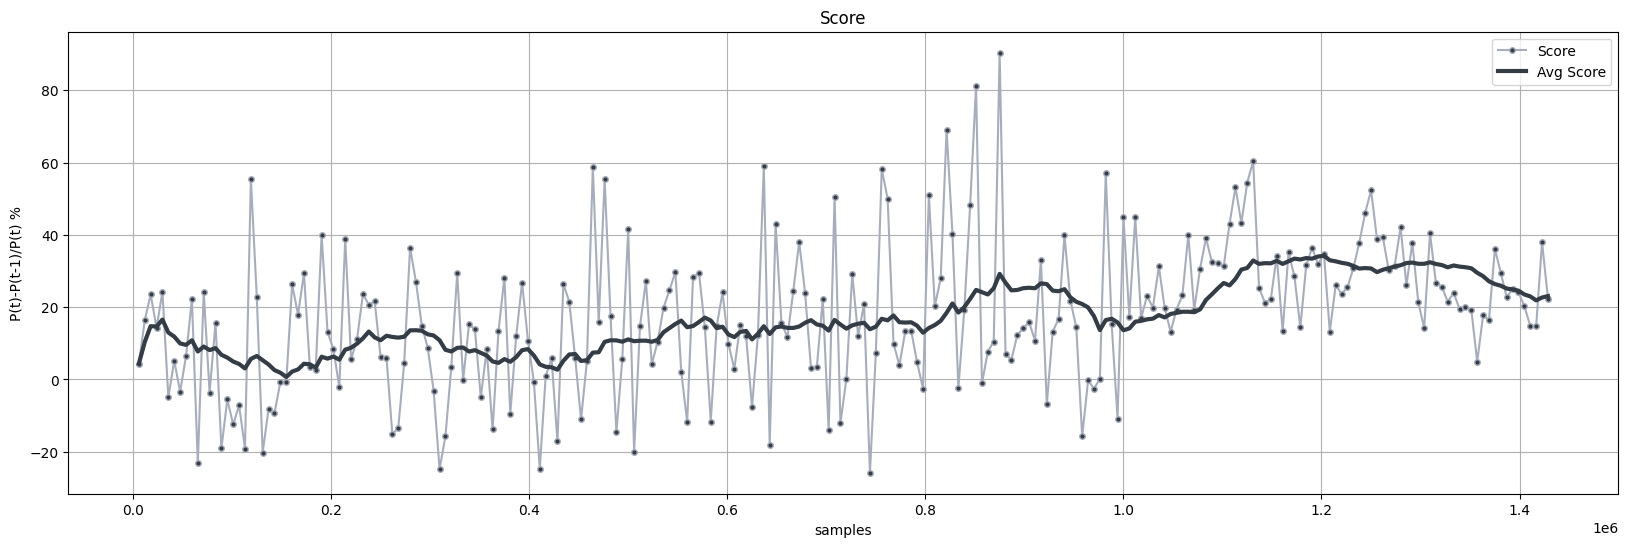

In [46]:
linear_chart_score(steps_array,scores,PATH)

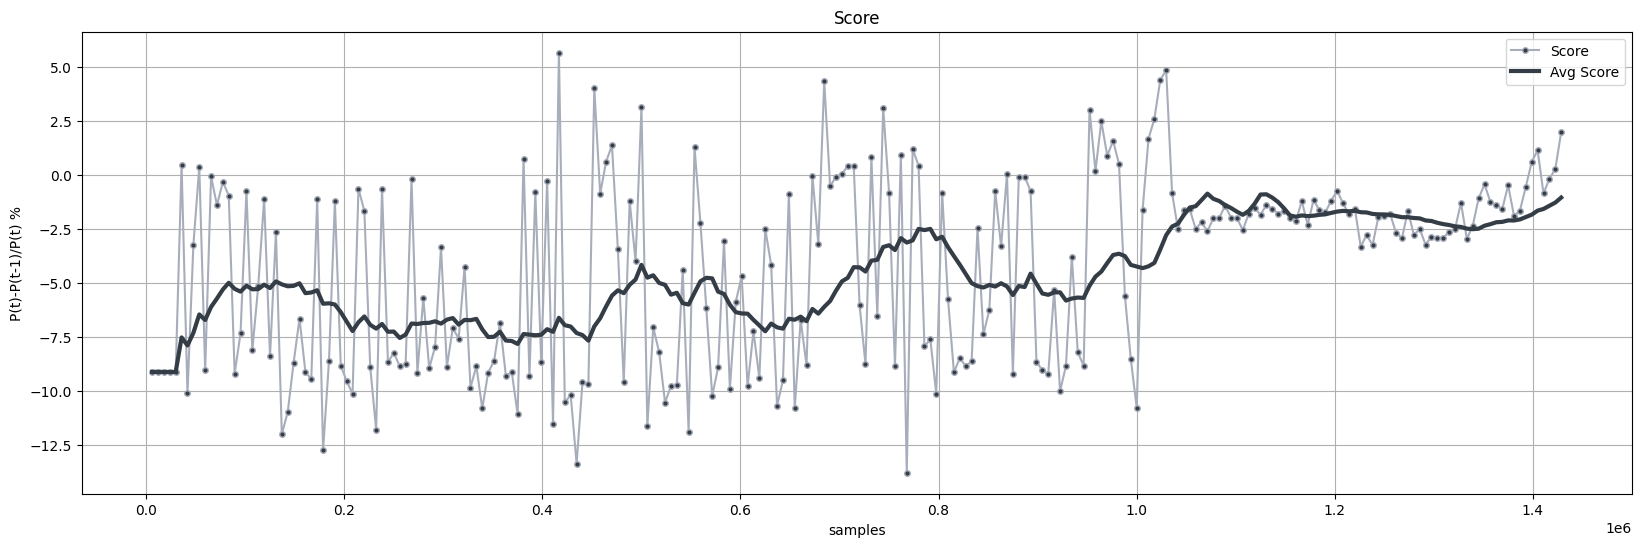

In [47]:
linear_chart_score(steps_array,scores_val,PATH)

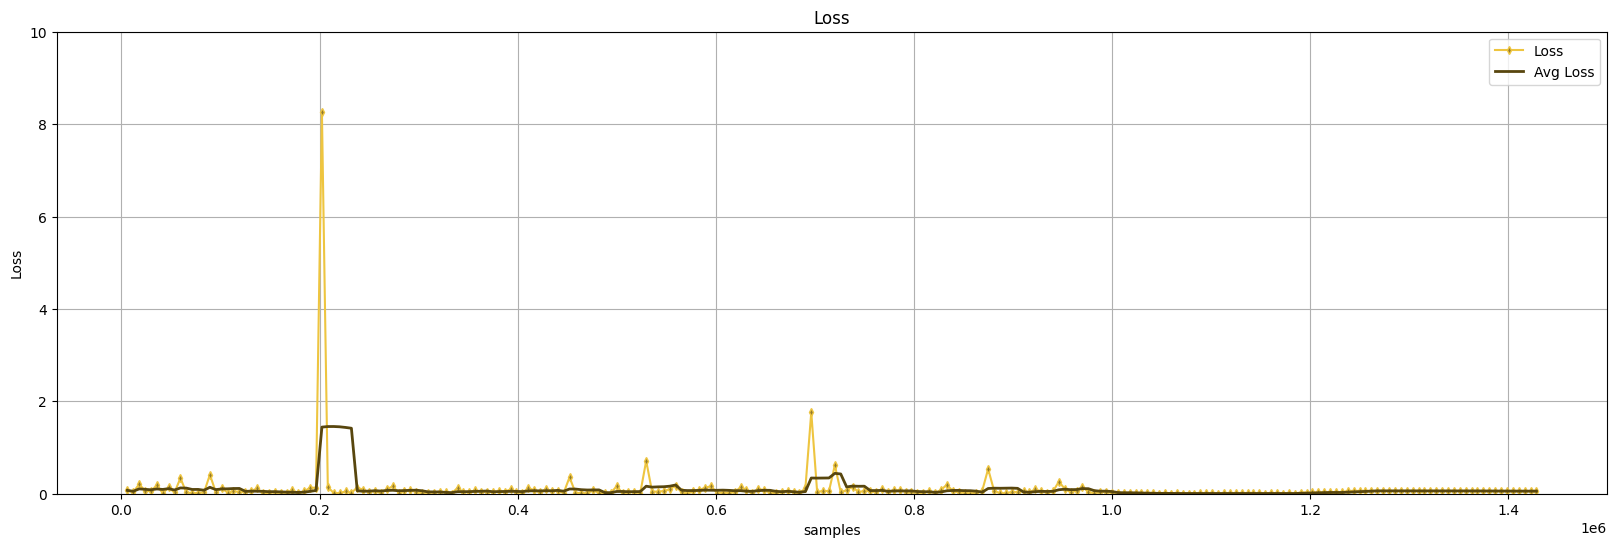

In [48]:
linear_chart_loss(steps_array,losses,PATH,10)

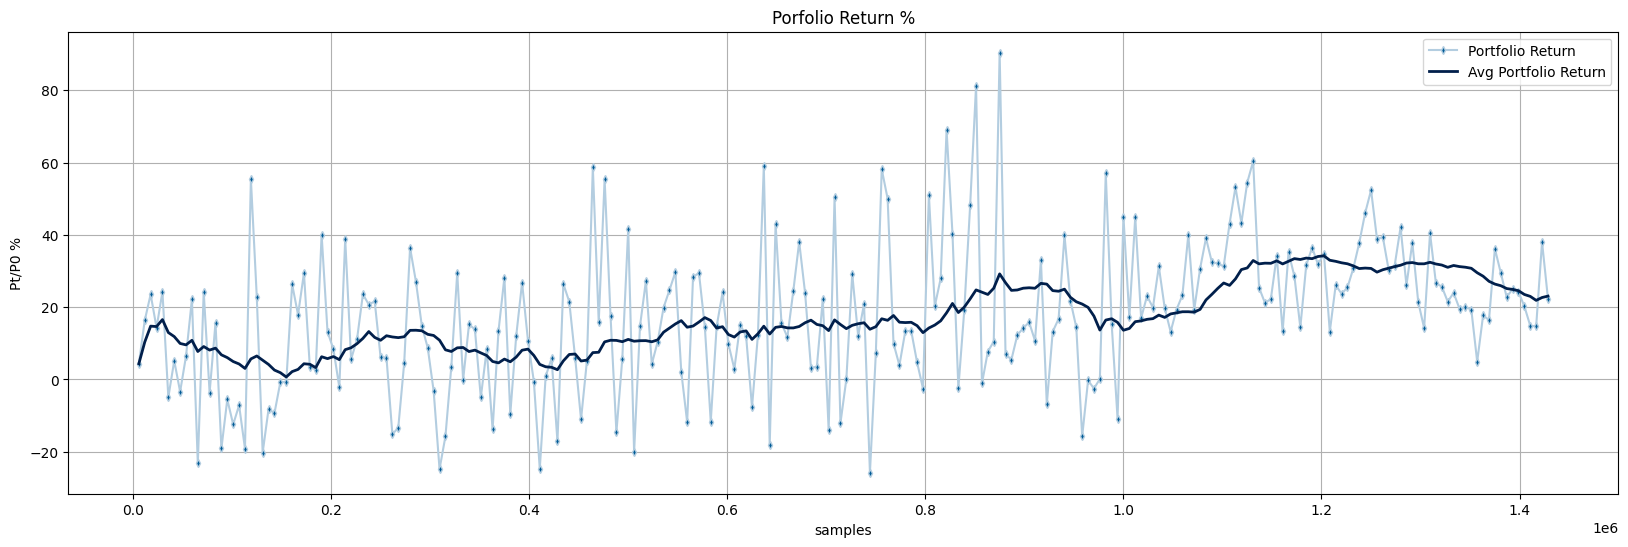

In [49]:
linear_chart_portfolio(steps_array,portfolios,PATH)

In [50]:
env.df.to_csv(f"{PATH}df_{string_folder}.csv")

In [51]:
env.df.head(50)

,index,date,hour,holidays,n_weekday,n_hour,open,high,low,close,...,feature_open,feature_high,feature_low,feature_volume,position,real_position,portfolio_valuation,Asset_value,Money_fiat,reward
0,3,2022-04-06,07:00:00,0,2,7,173.330000,173.350000,172.500000,172.680000,...,0.000000,0.000000,0.000000,0.000000,1,,100.0,100.0,0.0,0
1,4,2022-04-06,08:00:00,0,2,8,172.690000,175.230000,172.000000,172.620000,...,-0.003699,0.010787,-0.002903,0.000000,1,1.0,99.965254,99.965254,0.0,-0.034746
2,5,2022-04-06,09:00:00,0,2,9,172.360001,173.139999,171.020004,171.130005,...,-0.001913,-0.011999,-0.005714,0.000000,1,1.0,99.102389,99.102389,0.0,-0.862865
3,6,2022-04-06,10:00:00,0,2,10,171.130005,171.580002,170.130005,170.835007,...,-0.007162,-0.009051,-0.005218,-0.648580,1,1.0,98.931554,98.931554,0.0,-0.170835
4,7,2022-04-06,11:00:00,0,2,11,170.839996,171.740005,170.490005,170.975006,...,-0.001696,0.000932,0.002114,-0.370420,1,1.0,99.012628,99.012628,0.0,0.081074
5,8,2022-04-06,12:00:00,0,2,12,170.970001,171.710007,170.871506,171.710007,...,0.000761,-0.000175,0.002235,-0.319582,0,0.0,99.438271,0.0,99.438271,0.425643
6,9,2022-04-06,13:00:00,0,2,13,171.720001,173.410004,170.929993,171.380005,...,0.004377,0.009852,0.000342,0.675182,1,1.0,99.438271,99.438271,-0.0,0.0
7,10,2022-04-06,14:00:00,0,2,14,171.369995,173.630005,171.339996,171.669998,...,-0.002040,0.001268,0.002396,-0.000832,1,1.0,99.606531,99.606531,-0.0,0.16826
8,11,2022-04-06,15:00:00,0,2,15,171.675003,172.910004,171.509995,171.600006,...,0.001778,-0.004155,0.000992,-0.120322,0,0.0,99.565921,0.0,99.565921,-0.040611
9,12,2022-04-06,16:00:00,0,2,16,171.580000,171.990000,171.200000,171.330000,...,-0.000554,-0.005335,-0.001809,0.000000,0,0.0,99.565921,0.0,99.565921,0.0


In [52]:
env_val.df.head(50)

,index,date,hour,holidays,n_weekday,n_hour,open,high,low,close,...,feature_open,feature_high,feature_low,feature_volume,position,real_position,portfolio_valuation,Asset_value,Money_fiat,reward
0,16083,2024-02-05,07:00:00,0,0,7,186.300000,187.400000,185.780000,186.960000,...,0.000000,0.000000,0.000000,0.000000,1,,100.0,100.0,0.0,0
1,16084,2024-02-05,08:00:00,0,0,8,186.870000,187.580000,184.630000,186.850000,...,0.003055,0.000960,-0.006209,0.000000,0,0.0,99.941164,0.0,99.941164,-0.058836
2,16085,2024-02-05,09:00:00,0,0,9,188.149994,188.360001,185.839996,186.699997,...,0.006826,0.004150,0.006532,1.006693,0,0.0,99.941164,0.0,99.941164,0.0
3,16086,2024-02-05,10:00:00,0,0,10,186.669998,187.759995,186.110001,187.250000,...,-0.007897,-0.003191,0.001452,-1.022543,1,1.0,99.941164,99.941164,0.0,0.0
4,16087,2024-02-05,11:00:00,0,0,11,187.250000,188.490005,187.230103,188.429993,...,0.003102,0.003880,0.006000,-0.118919,1,1.0,100.570963,100.570963,0.0,0.629799
5,16088,2024-02-05,12:00:00,0,0,12,188.429993,189.250000,188.419998,188.540100,...,0.006282,0.004024,0.006335,0.074821,0,0.0,100.629731,0.0,100.629731,0.058768
6,16089,2024-02-05,13:00:00,0,0,13,188.540100,189.020004,188.384995,188.464996,...,0.000584,-0.001216,-0.000186,-0.471263,0,0.0,100.629731,0.0,100.629731,0.0
7,16090,2024-02-05,14:00:00,0,0,14,188.487000,188.839996,188.029999,188.350006,...,-0.000282,-0.000953,-0.001886,0.297031,1,1.0,100.629731,100.629731,-0.0,0.0
8,16091,2024-02-05,15:00:00,0,0,15,188.339996,188.419998,187.639999,187.669998,...,-0.000780,-0.002227,-0.002076,-0.054982,0,0.0,100.266423,0.0,100.266423,-0.363308
9,16092,2024-02-05,16:00:00,0,0,16,187.670000,200.257390,175.479370,187.750000,...,-0.003564,0.060930,-0.067004,0.000000,1,1.0,100.266423,100.266423,0.0,0.0
